In [14]:
import keras
import cv2
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## data generation

In [3]:
# path of images for training
train_path = "./images/training_images" 
# path of images for validation
valid_path = "./images/validation_images" 
# path of images for testing
test_path = "./images/test_images" 

In [4]:
# ImageDataGenerator is used for generating data
# flow_from_directory() generates batches of normalized tensor image data from the respective data directories.
# we provide path for directory in flow_from_directory() function
# target_size is size of the image and we use gray scale because many operations perform better in grayscale images
# class_mode will devide images into two class (open,closed)
# shuffle will shuffle the data everytime
# batch_size is number of batches we want to make from directory images
train_batches = ImageDataGenerator().flow_from_directory(
    directory=train_path, 
    target_size=(24,24),
    class_mode='categorical',
    shuffle=True, 
    batch_size=10, 
    color_mode='grayscale')
valid_batches = ImageDataGenerator().flow_from_directory(
    directory=valid_path, 
    target_size=(24,24),
    class_mode='categorical',
    shuffle=True, 
    batch_size=2, 
    color_mode='grayscale')
test_batches = ImageDataGenerator().flow_from_directory(
    directory=test_path, 
    target_size=(24,24),
    class_mode='categorical',
    shuffle=True, 
    batch_size=10, 
    color_mode='grayscale')

# We have 300 images in training_images , 20 images in validation_images and 40 images in test_images 

Found 300 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [5]:
# It has assigned 0 index to closed and 1 to open for every directory
print(test_batches.class_indices) 
print(train_batches.class_indices)
print(valid_batches.class_indices)

{'closed': 0, 'open': 1}
{'closed': 0, 'open': 1}
{'closed': 0, 'open': 1}


In [6]:
# collecting labels for test images
test_label = []  
count = 0
for i,j in test_batches:
    if count == 4:   # because we have total 40 images and 10 images per batch , so there will be 4 batch
        break        # if we will not break this , it will go into an infinite loop
    count+=1
    for k in j:
        test_label.append(k)  # appending labels to test_label

## data visualization

In [7]:
test_label = np.array(test_label) # defining numpy array for labels because faster and easier execution
print(test_label.shape)  # it contains array for all 40 images, [0,1] for open eye and [1,0] for closed eye 
print(type(test_label[0])) # test_label is a 2d numpy array
print(type(test_label))

(40, 2)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
for x,y in train_batches: # train_batches contains images and corresponding labels for that images
    print(x.shape) # x has 10 gray images (one batch) of size (24,24)
    print(y) # y contains label for one batch
    break # if we do not break , it will go into infinite loop

(10, 24, 24, 1)
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


[0. 1.]


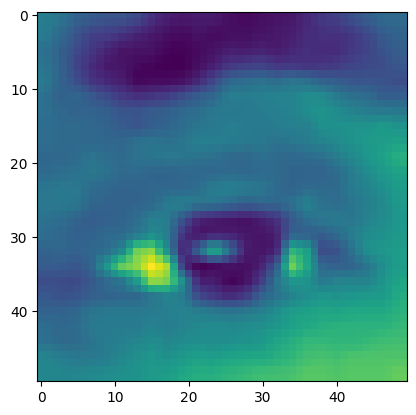

[0. 1.]


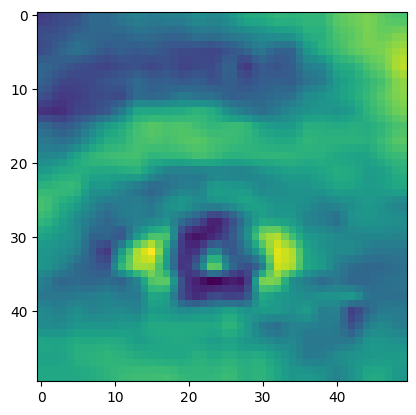

[0. 1.]


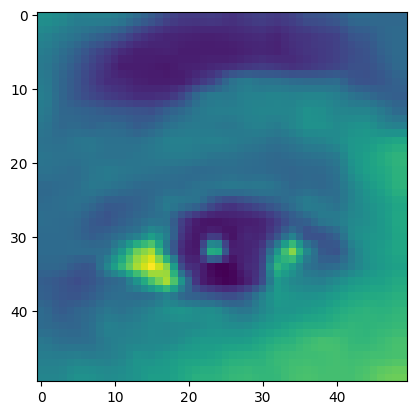

[0. 1.]


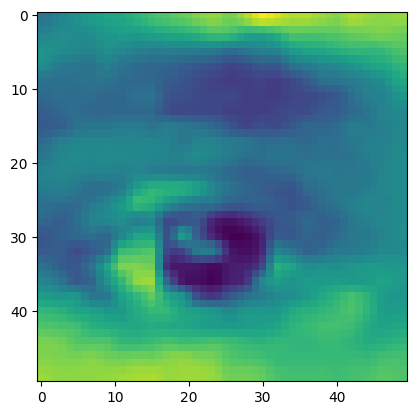

[1. 0.]


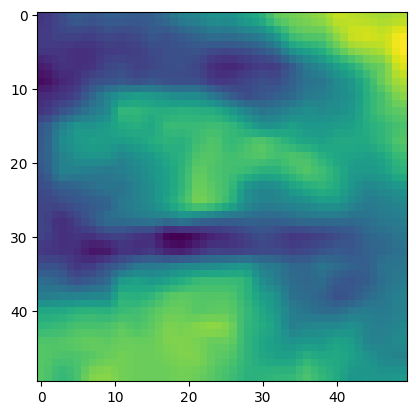

[1. 0.]


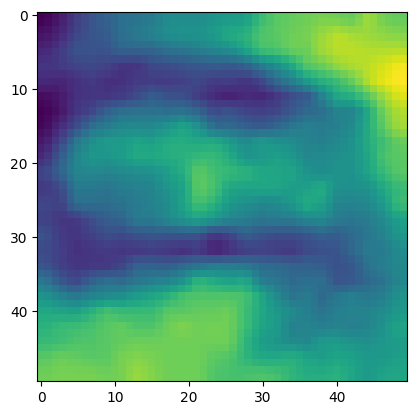

[1. 0.]


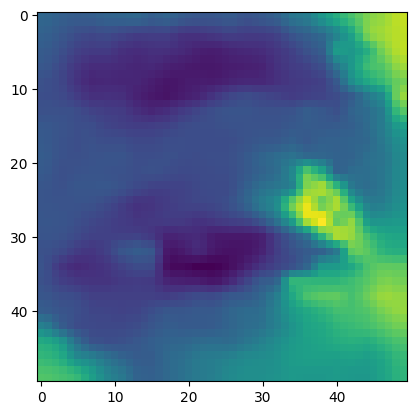

[1. 0.]


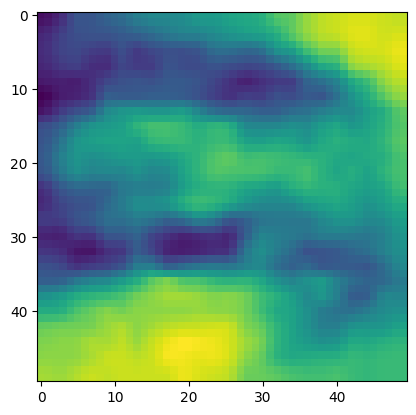

[0. 1.]


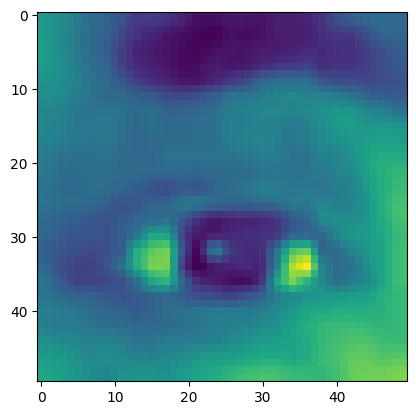

[0. 1.]


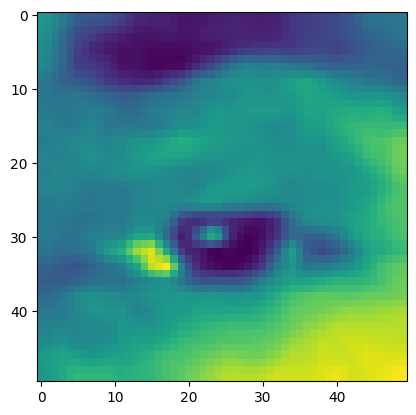

In [9]:
for imgs,labels in train_batches:
    for i in range(10):
        print(labels[i])
        img = cv2.resize(imgs[i],(50,50))  # resizing image for plotting
        plt.imshow(img) # plotting image
        plt.show()
    break

[0. 1.]


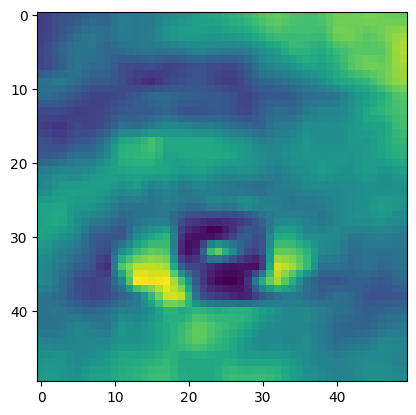

[1. 0.]


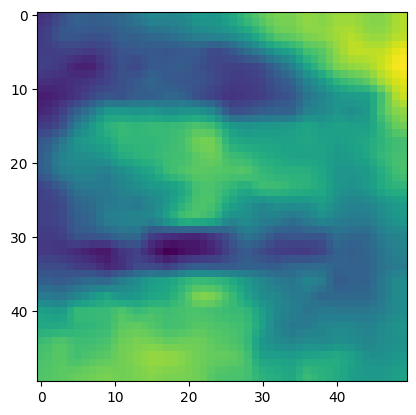

[0. 1.]


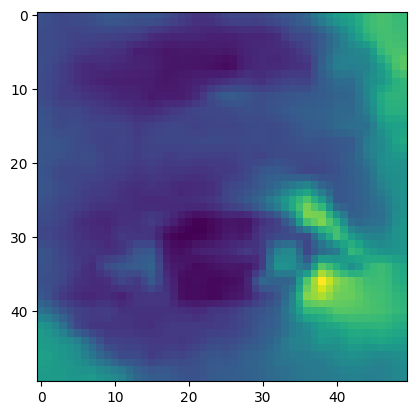

[0. 1.]


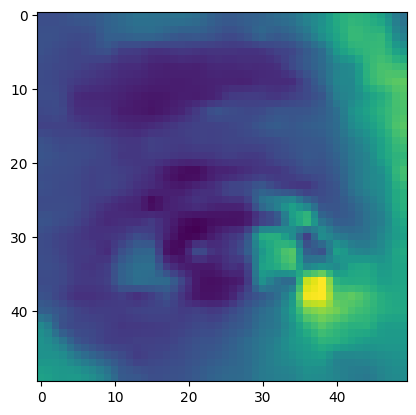

[1. 0.]


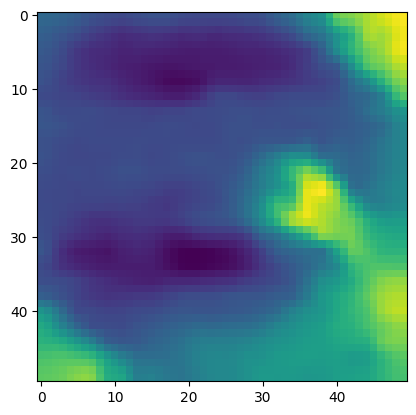

[1. 0.]


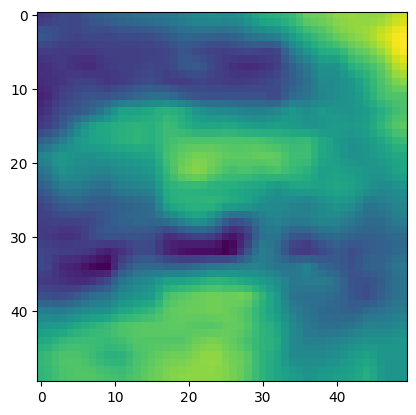

[1. 0.]


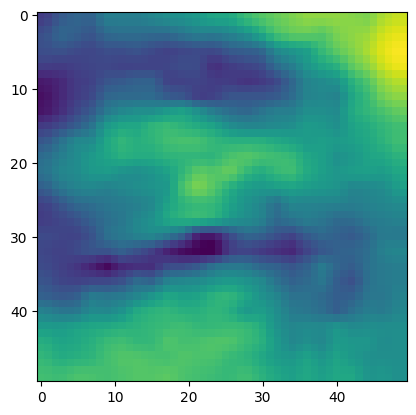

[1. 0.]


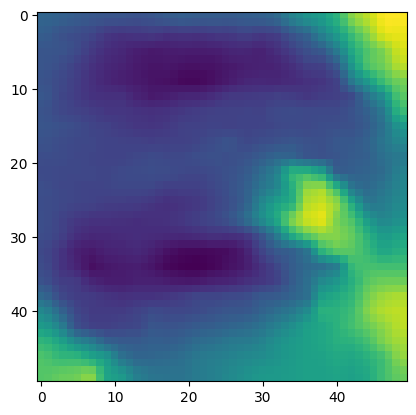

[0. 1.]


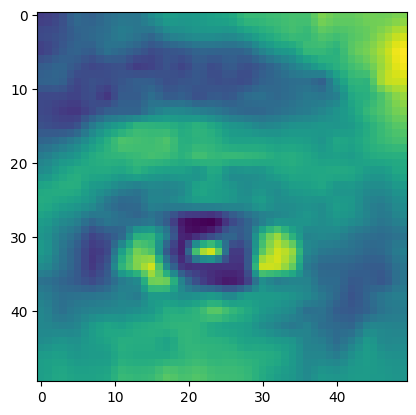

[0. 1.]


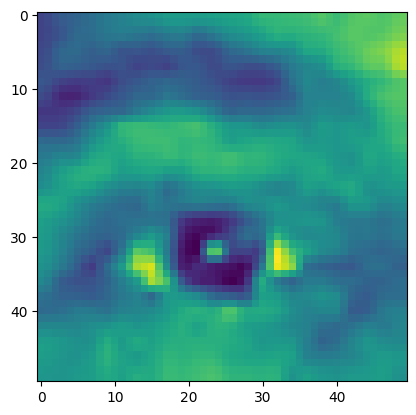

In [10]:
for imgs,labels in test_batches: # visualization of test images
    for i in range(10):
        print(labels[i])
        img = cv2.resize(imgs[i],(50,50))
        plt.imshow(img)
        plt.show()
    break

## Model Defination

In [15]:
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(24,24,1)),
    
    # A convolutional layer receives input,transforms the input in some way,and then outputs the transformed input to the next layer.
    # With each convolutional layer, we need to specify the number of filters the layer should have. These filters are actually
    # what detect the patterns like edges,objects,colors,shapes,curves etc.
    # In even deeper layers, the filters are able to detect even more sophisticated objects like full dogs, cats, birds.
    # A filter can technically just be thought of as a relatively small matrix ( tensor), for which, we decide the number of 
    # rows and columns this matrix has, and the values within this matrix are initialized with random numbers. 
    # we take the dot product of the filter with the first 3 x 3 block of pixels, and then that result is stored in the output channel.
    # Then, the filter slides to the next 3 x 3 block, computes the dot product, and stores the value as the next pixel in the output channel.
    
    # In an artificial neural network, an activation function is a function that maps a node's inputs to its corresponding output. 
    # as we know that every connection in network has some wights ,so we calculate the sum of products of input and weights and give
    # it to the activation function
    # relu(x) = max(0,X) so more positive the neuron is more activated it is
    
    layers.MaxPooling2D(pool_size=(1,1)),
    # When added to a model, max pooling reduces the dimensionality of images by reducing the 
    # number of pixels in the output from the previous convolutional layer
    # The first parameter we’re specifying is the pool_size. This is the size of what we were calling a filter before, and in our example, we used a 1 x 1 filter. 
    
    layers.Conv2D(32,(3,3),activation='relu'), 
    # another 2-dimentional convolutional layer because we are working with 2d images
    # 32 convolution filters used each of size 3x3

    layers.MaxPooling2D(pool_size=(1,1)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    # third convolutional layer
    # 64 convolution filters used each of size 3x3
    
    layers.MaxPooling2D(pool_size=(1,1)),
    # choose the best features via pooling
    
    # randomly turn neurons on and off to improve convergence
    layers.Dropout(0.25),

    # flatten since too many dimensions, we only want a classification output
    layers.Flatten(),

    # fully connected to get all relevant data
    layers.Dense(128, activation='relu'),

    # one more dropout for convergence' sake 
    layers.Dropout(0.5),

    # output a softmax to squash the matrix into output probabilities
    layers.Dense(2, activation='softmax')
    #we have two output nodes which denotes either open or closed
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary() # summary of our model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 22, 22, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,682,658 (10.23 MB)

 Trainable params: 2,682,658 (10.23 MB)

 Non-trainable params: 0 (0.00 B)

## training our model

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# The Adam optimization algorithm is an extension to stochastic gradient descent
# loss function is for calculating loss

In [19]:
model.fit(
    train_batches, 
    validation_data=valid_batches,
    epochs=15,
    steps_per_epoch=30,
    validation_steps=10,
    verbose=2
)
# our model will train on train_batches and will validate on valid_batches 
# we have make 15 epochs ,you can give any number
# verbose is 2, which just specifies the verbosity of the log output printed to the console during training. 
# we have 300 training images and 10 per batch so steps_per_epoch is 30
# we have 20 validation images and 2 per batch so validation_steps is 10

Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 - 1s - 47ms/step - accuracy: 0.7867 - loss: 6.5671 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 2/15
30/30 - 0s - 16ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/15
30/30 - 1s - 17ms/step - accuracy: 0.9967 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 2.3304e-05
Epoch 4/15
30/30 - 1s - 18ms/step - accuracy: 0.9900 - loss: 0.0297 - val_accuracy: 1.0000 - val_loss: 5.9605e-09
Epoch 5/15
30/30 - 1s - 17ms/step - accuracy: 0.9967 - loss: 0.0263 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/15
30/30 - 1s - 18ms/step - accuracy: 1.0000 - loss: 8.3854e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/15
30/30 - 0s - 16ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/15
30/30 - 0s - 16ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 9/15
30/30 - 0s - 16ms/step - accuracy: 0.9833 - loss: 0.0681 - val_accuracy: 1.0000 - val_lo

In [20]:
model.save('./models/myModel.h5', overwrite=True) 
# saving our model

In [22]:
predictions = model.predict(
    x=test_batches, 
    steps=4, 
    verbose=0
)
# making prediction about test_batches

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


## testing our model

In [25]:
from sklearn.metrics import confusion_matrix # for plotting confusion matrix
import itertools

In [26]:
print(predictions.shape) # prediction contain probability of classes for every image
print(type(predictions)) # it is a numpy array
print(type(predictions[0])) # it contains numpy array of probabilites of each class
print(predictions[0]) # first element is probability that image is from class closed and second is probability for open class
for i in predictions:
    i[0]=round(i[0]) # rounding the probabilities to convert them into 0 and 1
    i[1]=round(i[1])
print(predictions[0])

(40, 2)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[1.000000e+00 7.592189e-20]
[1. 0.]


In [27]:
cm = confusion_matrix(y_true=test_label[:,0], y_pred=predictions[:,0]) # making confusion matrix object

In [28]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    # This function prints and plots the confusion matrix.
    # Normalization can be applied by setting `normalize=True`.
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[10 10]
 [10 10]]


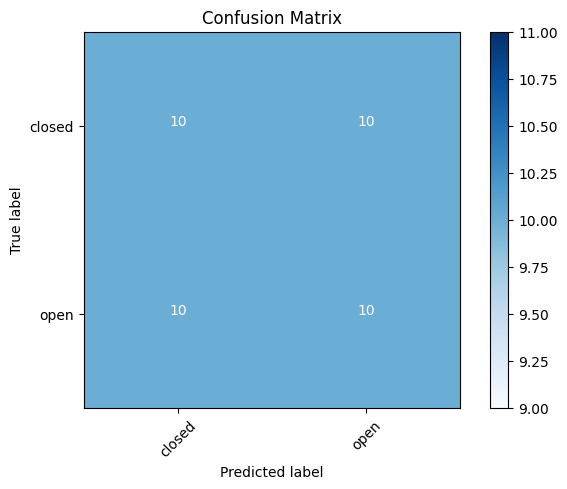

In [29]:
cm_plot_labels = ['closed','open']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix') # plotting confusion matrix

as we can see our model is not predicting well<br>
it has predicted 10 open eyes as closed eyes and 9 closed eyes as open eyes<br>
the reason can be the size of our dataset which is very small and all the images are taken in same intensity of light<br>
if images are taken in large amount and in different intesities it can predict well.